In [1]:
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

In [2]:
%cd /mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization/

/mnt/c/Users/efrai/Documentos/IDEAS/WORKSHOP/Improving_initialization


/home/emmt/anaconda3/envs/workshop/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
%autoreload 
from code_lib.Forward import *
from code_lib.Training import *

# 1D

In [4]:
def init_params_equis(layers, key):
  # Equisdi initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    c = jnp.linspace(-1, 1, layers[i + 1]+2)[1:-1]
    W = np.ones((layers[i], layers[i + 1]))
    W[::2,::2]*=-1

    Ws.append(W)  
    bs.append(-W[0]*c)
  return [Ws, bs]

In [19]:
layers = [1] + [32]*1 + [1]
bsize = 512*2
nIter = 1000
lr = 1e-3
stop_at = 1e-20
X = jnp.linspace(-1,1, 10000)[:, None]
f = lambda x:jnp.cos(x*2*jnp.pi)-1
df = lambda x:-2*jnp.pi*jnp.sin(x*2*jnp.pi)
d2f = lambda x:-4*jnp.pi**2*jnp.cos(x*2*jnp.pi)
Y = f(X)
dY = df(X)
d2Y = d2f(X)

trainer = Training2(optimizers.adam, {"lr":lr}, mode="MC")

key = jx.random.PRNGKey(0)

X_c = jnp.array([[-1,1]]).T
lmbi = 1e-2
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X_c, params, s)
    # _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = d2f(X)
    MSE =jnp.mean((Y_pred_g2.squeeze()-obj.squeeze())**2)*lmbi
    MSE+= jnp.mean((Y_pred-f(X_c))**2)
    return MSE

cases = {"he_normal":"he_normal", 
         "glorot_normal":"glorot_normal"}

for ini in cases.keys():
    params = init_params(layers, key, ini)
    opt_state = trainer.opt_init(params)
    params, train_loss, val_loss = trainer.train(loss, 
            X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
    cases[ini] = (params, train_loss)

params = init_params_equis(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["equis"] = (params, train_loss)

it 950, train loss = 5.201894e-01: 100%|████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.48it/s]


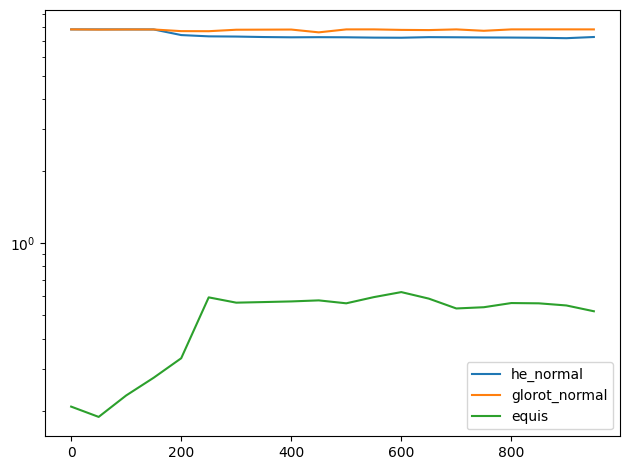

In [30]:
for ini in cases.keys():
    train_loss = cases[ini][1]
    plt.semilogy(np.arange(len(train_loss))*50, train_loss, label=ini)
plt.legend()
plt.tight_layout()
plt.show()

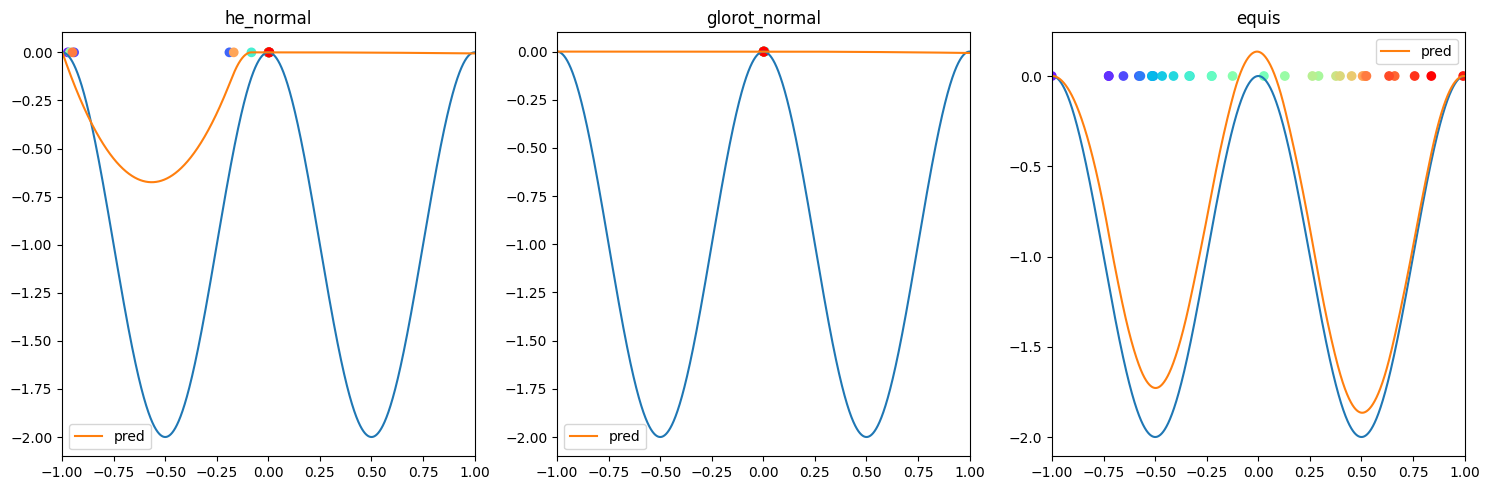

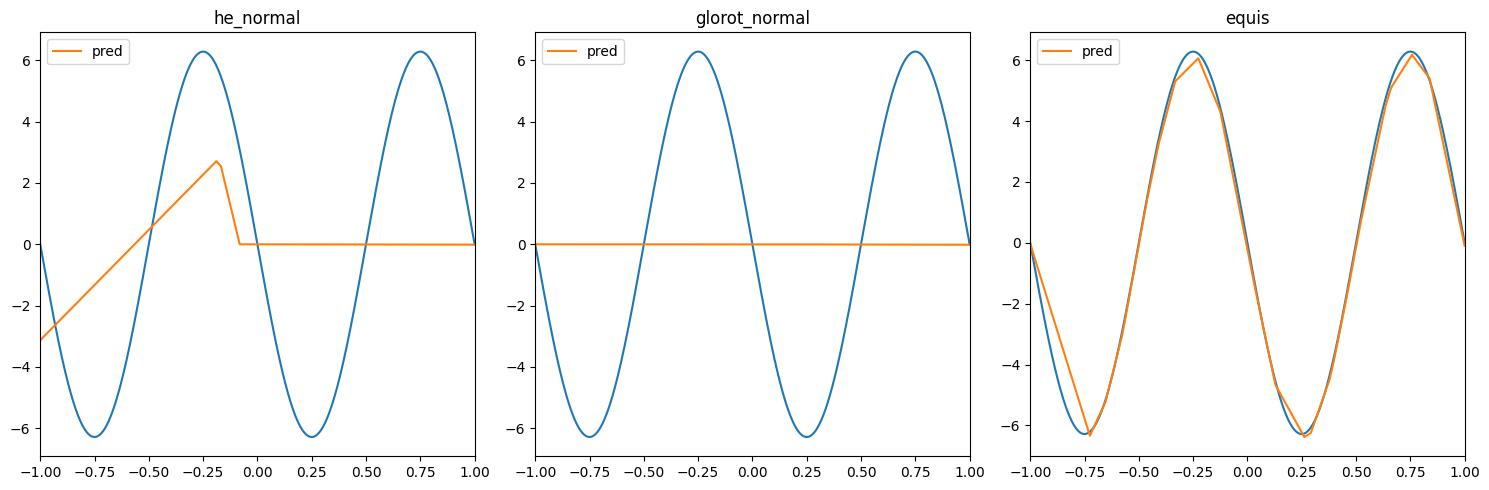

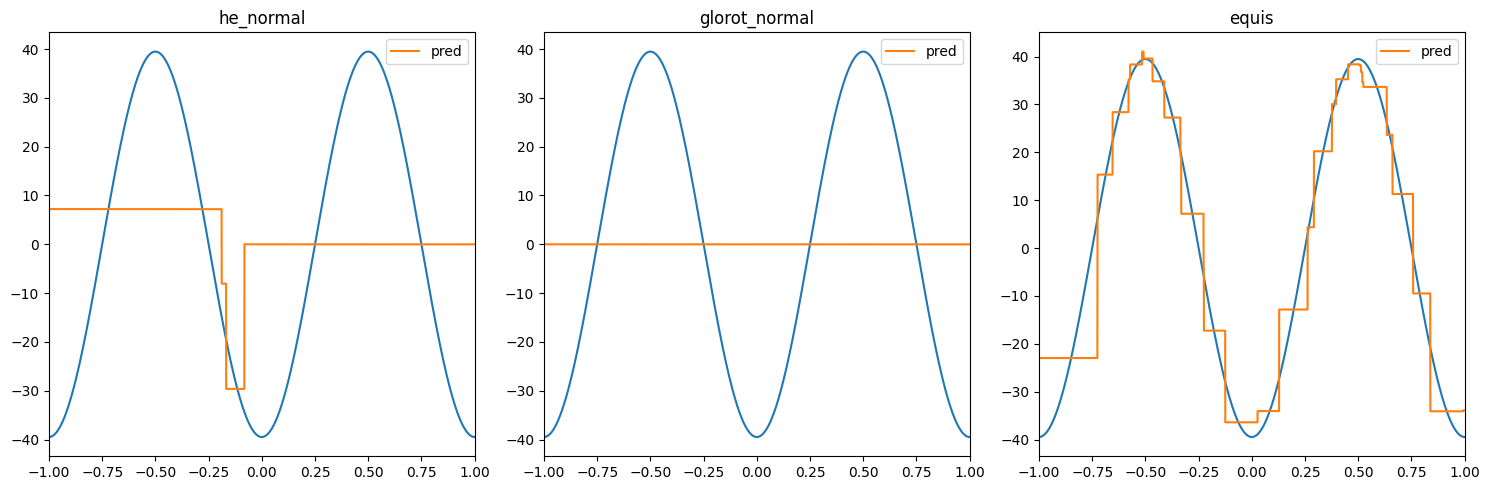

In [29]:
n_cases = len(cases.keys())
plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    W0, b0 = params
    W0 = W0[0]
    b0 = b0[0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, Y)
    plt.scatter(-b0/W0[0], [0]*b0.shape[0], c=np.linspace(0, 1, b0.shape[0]), cmap="rainbow")
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.plot(X, Y_pred, label="pred")
    plt.xlim(-1,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]

    plt.subplot(1, n_cases, j+1)
    plt.plot(X, dY)
    L, Y_pred = forward_pass_multi_grad(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(-1,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(5*n_cases, 5))
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    plt.subplot(1, n_cases, j+1)
    plt.plot(X, d2Y)
    L, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.plot(X, Y_pred.squeeze(), label="pred")
    plt.xlim(-1,1)
    plt.title(ini)
    plt.legend()
plt.tight_layout()
plt.show()


# 2D

In [31]:
def init_params_equis(layers, key):
  # Equisdi initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    mid_point = layers[i + 1]//2
    c = jnp.linspace(-1, 1, mid_point+2)[1:-1]
    c2 = jnp.linspace(-1, 1, layers[i + 1]-mid_point+2)[1:-1]
    c = jnp.hstack([c, c2])
    W = np.ones((layers[i], layers[i + 1]))
    W[:,::2]*=-1
    W[0, mid_point:]=0#1e-2
    W[1, :mid_point]=0#1e-2
    b = -W.sum(0)*c

    Ws.append(W)  
    bs.append(b)
  return [Ws, bs]

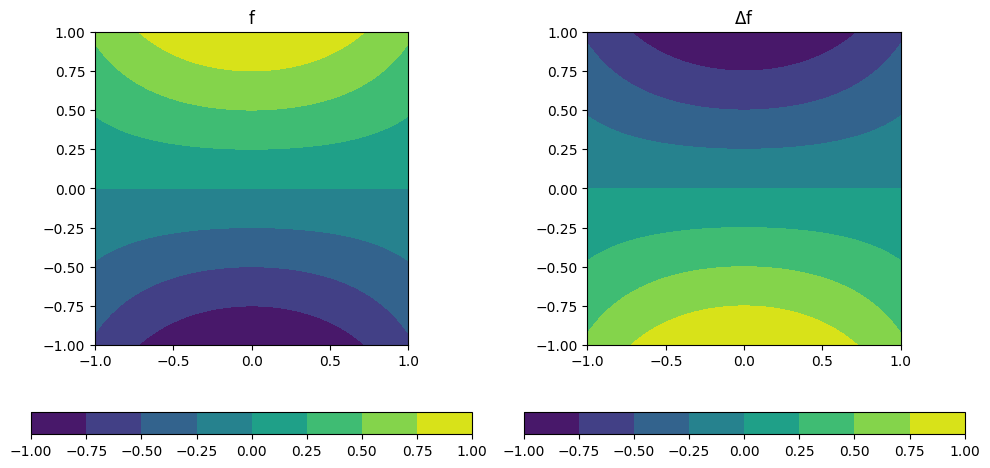

In [39]:
x = np.linspace(-1, 1, 200)
mesh = np.meshgrid(x, x)
X = np.c_[mesh[0].flatten(), mesh[1].flatten()]
f = lambda x:jnp.cos(x[:,0])*x[:,1]
dxf = lambda x:-jnp.sin(x[:,0])*x[:,1]
dyf = lambda x: jnp.con(x[:,0])
dxxf = lambda x:-jnp.cos(x[:,0])*x[:,1]
dyyf = lambda x: x[:,0]*0
dxyf = lambda x: -jnp.sin(x[:,0])
laplace = lambda x: dxxf(x)+dyyf(x)

Y = f(X)[:,None]
Ylaplace = laplace(X)[:,None]

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("f")
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.subplot(1,2,2)
plt.title(r"$\Delta$f")
plt.contourf(*mesh, Ylaplace.reshape(mesh[0].shape))
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.tight_layout()
plt.show()

In [40]:
layers = [2] + [32]*1 + [1]
bsize = 512*2
nIter = 1000
lr = 1e-3
stop_at = 1e-20
trainer = Training2(optimizers.adam, {"lr":lr}, mode="MC")

key = jx.random.PRNGKey(0)
X_c = np.c_[np.c_[x,x*0-1].T,np.c_[x,x*0+1].T, np.c_[x*0-1, x].T, np.c_[x*0+1, x].T].T
lmbi = 1e-2
@jx.jit
def loss(params, s, X, Y, X_c):
    _, Y_pred = forward_pass_multi(X_c, params, s)
    # _, Y_pred_g = forward_pass_multi_grad(X, params, s)
    _, Y_pred_g2 = forward_pass_multi_grad2(X, params, s)
    obj = laplace(X)
    pred_laplcae = Y_pred_g2[:,0,0,0]+ Y_pred_g2[:,0,1,1]
    MSE =jnp.mean((pred_laplcae-obj.squeeze())**2)*lmbi
    MSE+= jnp.mean((Y_pred.squeeze()-f(X_c))**2)
    return MSE

cases = {"he_normal":"he_normal", 
         "glorot_normal":"glorot_normal"}

for ini in cases.keys():
    params = init_params(layers, key, ini)
    opt_state = trainer.opt_init(params)
    params, train_loss, val_loss = trainer.train(loss, 
            X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
    cases[ini] = (params, train_loss)

params = init_params_equis(layers, key)
opt_state = trainer.opt_init(params)
params, train_loss, val_loss = trainer.train(loss, 
        X, Y, X_c, opt_state, bsize=bsize, nIter = nIter, stop=stop_at)
cases["equis"] = (params, train_loss)

it 950, train loss = 1.407773e-03: 100%|████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.43it/s]


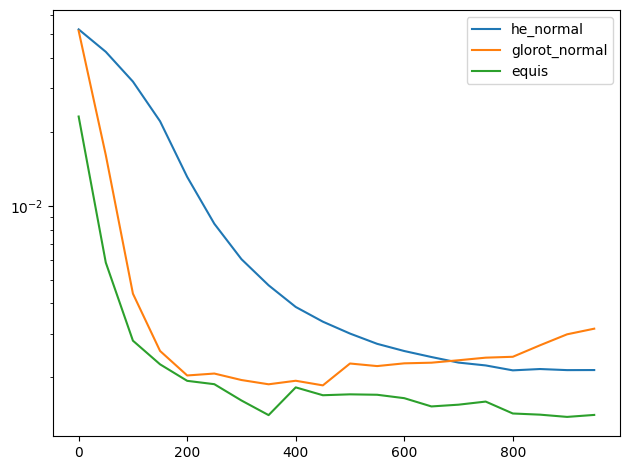

In [41]:
for ini in cases.keys():
    train_loss = cases[ini][1]
    plt.semilogy(np.arange(len(train_loss))*50, train_loss, label=ini)
plt.legend()
plt.tight_layout()
plt.show()

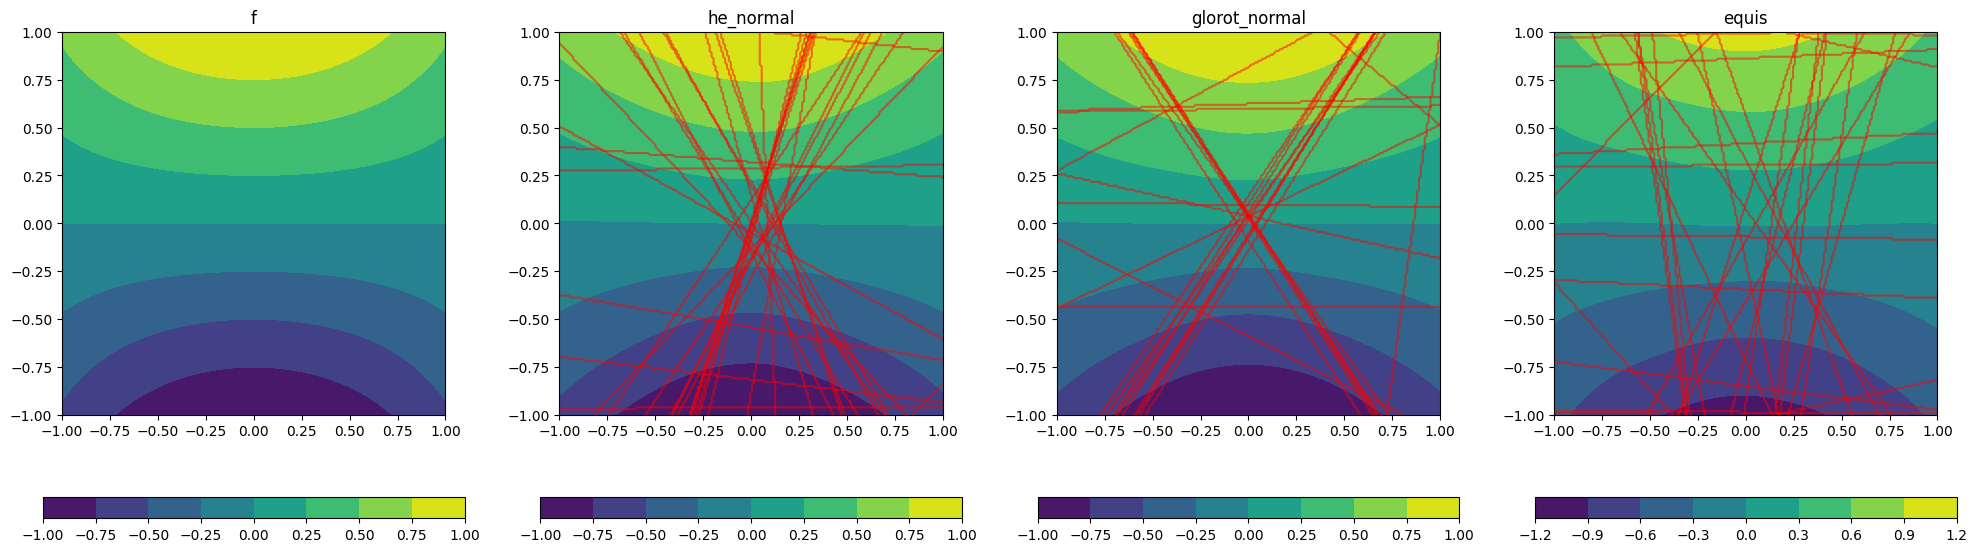

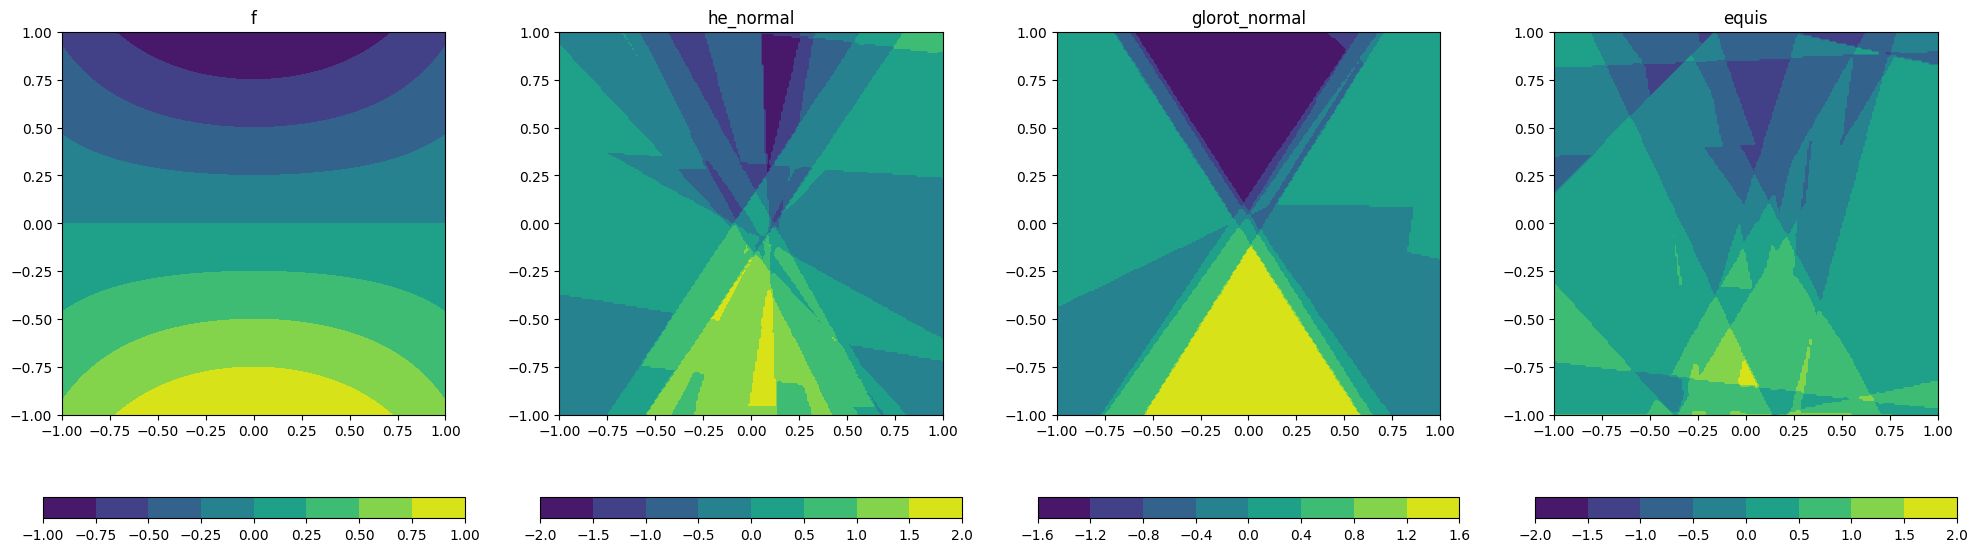

In [ ]:
n_cases = len(cases.keys())
plt.figure(figsize=(5*n_cases+5, 5+1))    
plt.subplot(1, n_cases+1, 1)
plt.contourf(*mesh, Y.reshape(mesh[0].shape))
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.title("f")
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    plt.subplot(1, n_cases+1, j+2)
    L, Y_pred = forward_pass_multi(X, params, params[0][-1])
    plt.contourf(*mesh, Y_pred.reshape(mesh[0].shape))
    plt.colorbar(orientation="horizontal")
    for i in range(L.shape[1]):
        plt.contour(*mesh, L[:,i].reshape(mesh[0].shape), 
                    levels=[0], colors="red", alpha=0.5)
    plt.title(ini)
    plt.axis("scaled")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5*n_cases+5, 5+1))    
plt.subplot(1, n_cases+1, 1)
plt.contourf(*mesh, Ylaplace.reshape(mesh[0].shape))
plt.colorbar(orientation="horizontal")
plt.axis("scaled")
plt.title("f")
for j, ini in enumerate(cases.keys()):
    params = cases[ini][0]
    plt.subplot(1, n_cases+1, j+2)
    _, Y_pred = forward_pass_multi_grad2(X, params, params[0][-1])
    plt.contourf(*mesh, (Y_pred[:,:,0,0]+Y_pred[:,:,1,1]).reshape(mesh[0].shape))
    plt.colorbar(orientation="horizontal")
    plt.title(ini)
    plt.axis("scaled")
plt.tight_layout()
plt.show()